# Depth Estimation Model
## Computer Vision TPA 10

## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
!pip uninstall -y torch torchvision torchaudio torchtext

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0


In [ ]:
!pip install torch==2.0.0 torchvision torchaudio torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import h5py
# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.0+cu117'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)

1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading RGB Images and Depth Images from the specified root folder which contains mat file:
The following import code expects the root directory to contain mat files of all input rgb and depth images

In [ ]:
# Locate the file you want to import
root_directory = '/content/drive/MyDrive/Dataset'

In [ ]:
from scipy.io import loadmat

In [ ]:
import os
import numpy as np

In [ ]:
images = []
depths = []

# Traverse the directory to find .mat files
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file.endswith('.mat'):
            file_path = os.path.join(root, file)
            obj = loadmat(file_path)
            images.append(obj['data']['rgb'][0][0])
            depths.append(obj['data']['depth'][0][0])

In [ ]:
images_test = np.array(images)
depths_test = np.array(depths)

## Visualizing:
We visualise an image and its corresponding depth map.

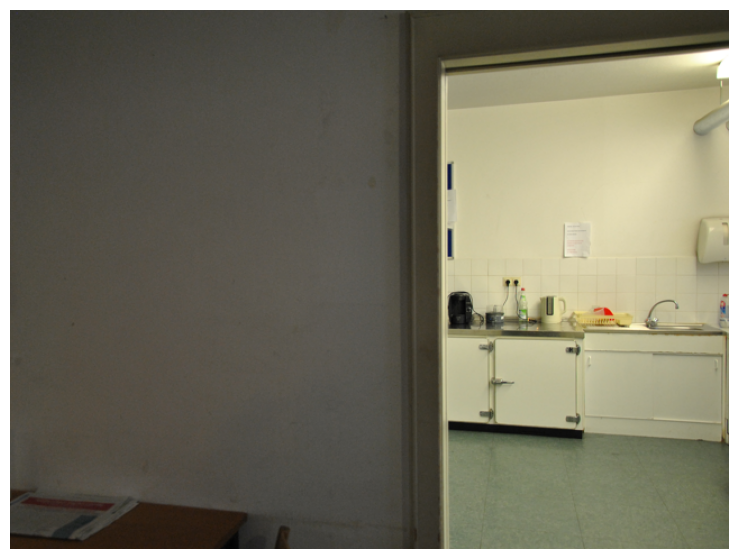

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(images[0])
#img_as_array = np.transpose(img_as_array)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.axis(False);

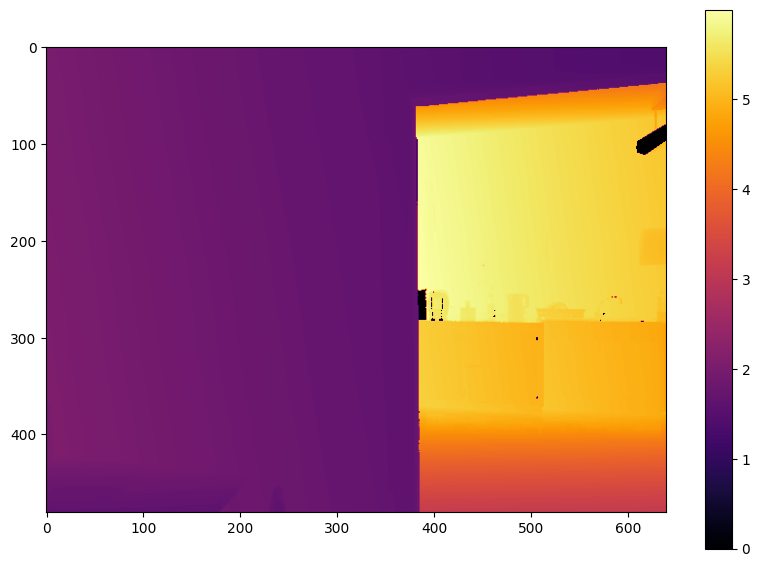

In [ ]:
img_as_array = np.asarray(depths[0])
#img_as_array = np.transpose(img_as_array, (1, 0))
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array,cmap='inferno')
plt.colorbar()
plt.show()

## Configuration:
This is to create a config dict that would later be used to build and train the mode. This would contain the specifications.

In [ ]:
class edict(dict):

    def __init__(self, d=None, **kwargs):
        if d is None:
            d = {}
        else:
            d = dict(d)
        if kwargs:
            d.update(**kwargs)
        for k, v in d.items():
            setattr(self, k, v)
        # Class attributes
        for k in self.__class__.__dict__.keys():
            if not (k.startswith('__') and k.endswith('__')) and not k in ('update', 'pop'):
                setattr(self, k, getattr(self, k))

    def __setattr__(self, name, value):
        if isinstance(value, (list, tuple)):
            value = [self.__class__(x)
                     if isinstance(x, dict) else x for x in value]
        elif isinstance(value, dict) and not isinstance(value, self.__class__):
            value = self.__class__(value)
        super(edict, self).__setattr__(name, value)
        super(edict, self).__setitem__(name, value)

    __setitem__ = __setattr__

    def update(self, e=None, **f):
        d = e or dict()
        d.update(f)
        for k in d:
            setattr(self, k, d[k])

    def pop(self, k, d=None):
        delattr(self, k)
        return super(edict, self).pop(k, d)


In [ ]:
def infer_type(x):  # hacky way to infer type from string args
    if not isinstance(x, str):
        return x

    try:
        x = int(x)
        return x
    except ValueError:
        pass

    try:
        x = float(x)
        return x
    except ValueError:
        pass

    return x

In [ ]:
import json
import os


import pathlib
import platform


COMMON_CONFIG = {
    "save_dir": "/content/drive/MyDrive/zoedepth/model_checkpoints",
    "project": "ZoeDepth",
    "tags": '',
    "notes": "",
    "gpu": 0,
    "root": "/content/drive/MyDrive/zoedepth/images",
    "uid": None,
    "print_losses": True
}

DATASETS_CONFIG = {

    "nyu": {
        "dataset": "nyu",
        "avoid_boundary": False,
        "min_depth": 1e-3,   # originally 0.1
        "max_depth": 10,
        "input_height": 480,
        "input_width": 640,
        "min_depth_eval": 1e-3,
        "max_depth_eval": 10,
        "min_depth_diff": -10,
        "max_depth_diff": 10,

        "do_random_rotate": False,
        "degree": 1.0,
        "do_kb_crop": False,
        "garg_crop": False,
        "eigen_crop": True
    },
    "ibims": {
        "dataset": "ibims",
        "eigen_crop": True,
        "garg_crop": False,
        "do_kb_crop": False,
        "min_depth_eval": 0,
        "max_depth_eval": 10,
        "min_depth": 1e-3,
        "max_depth": 10
    },
    "sunrgbd": {
        "dataset": "sunrgbd",
        "eigen_crop": True,
        "garg_crop": False,
        "do_kb_crop": False,
        "min_depth_eval": 0,
        "max_depth_eval": 8,
        "min_depth": 1e-3,
        "max_depth": 10
    },
    "diml_indoor": {
        "dataset": "diml_indoor",
        "eigen_crop": True,
        "garg_crop": False,
        "do_kb_crop": False,
        "min_depth_eval": 0,
        "max_depth_eval": 10,
        "min_depth": 1e-3,
        "max_depth": 10
    },

    "diode_indoor": {
        "dataset": "diode_indoor",
        "eigen_crop": True,
        "garg_crop": False,
        "do_kb_crop": False,
        "min_depth_eval": 1e-3,
        "max_depth_eval": 10,
        "min_depth": 1e-3,
        "max_depth": 10
    },

    "hypersim_test": {
        "dataset": "hypersim_test",
        "eigen_crop": True,
        "garg_crop": False,
        "do_kb_crop": False,
        "min_depth_eval": 1e-3,
        "max_depth_eval": 80,
        "min_depth": 1e-3,
        "max_depth": 10
    },
}

ALL_INDOOR = ["nyu", "ibims", "sunrgbd", "diode_indoor", "hypersim_test"]
ALL_OUTDOOR = ["kitti", "diml_outdoor", "diode_outdoor",  "vkitti2", "ddad"]
ALL_EVAL_DATASETS = ALL_INDOOR + ALL_OUTDOOR

COMMON_TRAINING_CONFIG = {
    "dataset": "nyu",
    "distributed": False,
    "workers": 2,
    "clip_grad": 0.1,
    "use_shared_dict": False,
    "shared_dict": None,
    "use_amp": False,

    "aug": False,
    "random_crop": False,
    "random_translate": False,
    "translate_prob": 0.2,
    "max_translation": 100,

    "validate_every": 0.25,
    "log_images_every": 0.01,
    "prefetch": False,
    "shuffle_eval": False
}


def flatten(config, except_keys=('bin_conf')):
    def recurse(inp):
        if isinstance(inp, dict):
            for key, value in inp.items():
                if key in except_keys:
                    yield (key, value)
                if isinstance(value, dict):
                    yield from recurse(value)
                else:
                    yield (key, value)

    return dict(list(recurse(config)))


def split_combined_args(kwargs):
    """Splits the arguments that are combined with '__' into multiple arguments.
       Combined arguments should have equal number of keys and values.
       Keys are separated by '__' and Values are separated with ';'.
       For example, '__n_bins__lr=256;0.001'

    Args:
        kwargs (dict): key-value pairs of arguments where key-value is optionally combined according to the above format.

    Returns:
        dict: Parsed dict with the combined arguments split into individual key-value pairs.
    """
    new_kwargs = dict(kwargs)
    for key, value in kwargs.items():
        if key.startswith("__"):
            keys = key.split("__")[1:]
            values = value.split(";")
            assert len(keys) == len(
                values), f"Combined arguments should have equal number of keys and values. Keys are separated by '__' and Values are separated with ';'. For example, '__n_bins__lr=256;0.001. Given (keys,values) is ({keys}, {values})"
            for k, v in zip(keys, values):
                new_kwargs[k] = v
    return new_kwargs


def parse_list(config, key, dtype=int):
    """Parse a list of values for the key if the value is a string. The values are separated by a comma.
    Modifies the config in place.
    """
    if key in config:
        if isinstance(config[key], str):
            config[key] = list(map(dtype, config[key].split(',')))
        assert isinstance(config[key], list) and all([isinstance(e, dtype) for e in config[key]]
                                                     ), f"{key} should be a list of values dtype {dtype}. Given {config[key]} of type {type(config[key])} with values of type {[type(e) for e in config[key]]}."


def get_model_config(model_name, model_version=None):
    """Find and parse the .json config file for the model.

    Args:
        model_name (str): name of the model. The config file should be named config_{model_name}[_{model_version}].json under the models/{model_name} directory.
        model_version (str, optional): Specific config version. If specified config_{model_name}_{model_version}.json is searched for and used. Otherwise config_{model_name}.json is used. Defaults to None.

    Returns:
        easydict: the config dictionary for the model.
    """
    config_fname = f"config_{model_name}_{model_version}.json" if model_version is not None else f"config_{model_name}.json"
    config_file = f"/content/drive/MyDrive/zoedepth/{config_fname}"

    with open(config_file, "r") as f:
        config = edict(json.load(f))

    # handle dictionary inheritance
    # only training config is supported for inheritance
    if "inherit" in config.train and config.train.inherit is not None:
        inherit_config = get_model_config(config.train["inherit"]).train
        for key, value in inherit_config.items():
            if key not in config.train:
                config.train[key] = value
    return edict(config)


def update_model_config(config, mode, model_name, model_version=None, strict=False):
    model_config = get_model_config(model_name, model_version)
    if model_config is not None:
        config = {**config, **
                  flatten({**model_config.model, **model_config[mode]})}
    elif strict:
        raise ValueError(f"Config file for model {model_name} not found.")
    return config


def check_choices(name, value, choices):
    # return  # No checks in dev branch
    if value not in choices:
        raise ValueError(f"{name} {value} not in supported choices {choices}")


KEYS_TYPE_BOOL = ["use_amp", "distributed", "use_shared_dict", "same_lr", "aug", "three_phase",
                  "prefetch", "cycle_momentum"]  # Casting is not necessary as their int casted values in config are 0 or 1


def get_config(model_name, mode='train', dataset=None, **overwrite_kwargs):
    """Main entry point to get the config for the model.

    Args:
        model_name (str): name of the desired model.
        mode (str, optional): "train" or "infer". Defaults to 'train'.
        dataset (str, optional): If specified, the corresponding dataset configuration is loaded as well. Defaults to None.

    Keyword Args: key-value pairs of arguments to overwrite the default config.

    The order of precedence for overwriting the config is (Higher precedence first):
        # 1. overwrite_kwargs
        # 2. "config_version": Config file version if specified in overwrite_kwargs. The corresponding config loaded is config_{model_name}_{config_version}.json
        # 3. "version_name": Default Model version specific config specified in overwrite_kwargs. The corresponding config loaded is config_{model_name}_{version_name}.json
        # 4. common_config: Default config for all models specified in COMMON_CONFIG

    Returns:
        easydict: The config dictionary for the model.
    """


    check_choices("Model", model_name, ["zoedepth", "zoedepth_nk"])
    check_choices("Mode", mode, ["train", "infer", "eval"])
    if mode == "train":
        check_choices("Dataset", dataset, ["nyu", "kitti", "mix", None])

    config = flatten({**COMMON_CONFIG, **COMMON_TRAINING_CONFIG})
    config = update_model_config(config, mode, model_name)

    # update with overwrite_kwargs
    # Combined args are useful for hyperparameter search
    overwrite_kwargs = split_combined_args(overwrite_kwargs)
    config = {**config, **overwrite_kwargs}

    # Casting to bool   # TODO: Not necessary. Remove and test
    for key in KEYS_TYPE_BOOL:
        if key in config:
            config[key] = bool(config[key])

    # Model specific post processing of config
    parse_list(config, "n_attractors")

    # adjust n_bins for each bin configuration if bin_conf is given and n_bins is passed in overwrite_kwargs
    if 'bin_conf' in config and 'n_bins' in config:
        bin_conf = config['bin_conf']  # list of dicts
        n_bins = config['n_bins']
        new_bin_conf = []
        for conf in bin_conf:
            conf['n_bins'] = n_bins
            new_bin_conf.append(conf)
        config['bin_conf'] = new_bin_conf

    if mode == "train":
        orig_dataset = dataset
        if dataset == "mix":
            dataset = 'nyu'  # Use nyu as default for mix. Dataset config is changed accordingly while loading the dataloader
        if dataset is not None:
            config['project'] = f"MonoDepth3-{orig_dataset}"  # Set project for wandb

    if dataset is not None:
        config['dataset'] = dataset
        config = {**DATASETS_CONFIG[dataset], **config}


    config['model'] = model_name
    typed_config = {k: infer_type(v) for k, v in config.items()}
    # add hostname to config
    config['hostname'] = platform.node()
    return edict(typed_config)


def change_dataset(config, new_dataset):
    config.update(DATASETS_CONFIG[new_dataset])
    return config

In [ ]:
config = get_config("zoedepth", "train","nyu")

In [ ]:
from pprint import pprint
print("Config:")
pprint(config)

Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': False,
 'avoid_boundary': False,
 'batch_size': 3,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'bs': 3,
 'clip_grad': 0.1,
 'cycle_momentum': True,
 'dataset': 'nyu',
 'degree': 1.0,
 'distributed': False,
 'div_factor': 1,
 'do_kb_crop': False,
 'do_random_rotate': False,
 'eigen_crop': True,
 'encoder_lr_factor': 10,
 'epochs': 100,
 'final_div_factor': 10000,
 'freeze_midas_bn': True,
 'garg_crop': False,
 'gpu': 0,
 'img_size': 384,
 'input_height': 480,
 'input_width': 640,
 'inverse_midas': False,
 'log_images_every': 0.01,
 'lr': 0.000161,
 'max_depth': 10,
 'max_depth_diff': 10,
 'max_depth_eval': 10,
 'max_temp': 50.0,
 'max_translation': 100,
 'memory_efficient': True,
 'midas_lr_factor': 1,
 'midas_model_type': 'DPT_SwinV2_B_384',
 'min_depth': 0.001,
 'min_depth_diff': -10,
 'min_depth_eval': 0.001,
 'min_temp': 0.0212,
 'model': 'zoedepth',

## Model:
We now build the model architecture. The model contains core (Midas) and a single depth metric head that predicts true depth from the relative depth estimate of the core.

In [ ]:
import sys
sys.path.append('/content/drive/My Drive')
from importlib import import_module
from zoedepth.models.depth_model import DepthModel

def build_model(config) -> DepthModel:
    """Builds a model from a config. The model is specified by the model name and version in the config. The model is then constructed using the build_from_config function of the model interface.
    This function should be used to construct models for training and evaluation.

    Args:
        config (dict): Config dict. Config is constructed in utils/config.py. Each model has its own config file(s) saved in its root model folder.

    Returns:
        torch.nn.Module: Model corresponding to name and version as specified in config
    """
    module_name = f"zoedepth.models.{config.model}"
    try:
        module = import_module(module_name)
    except ModuleNotFoundError as e:
        # print the original error message
        print(e)
        raise ValueError(
            f"Model {config.model} not found. Refer above error for details.") from e
    try:
        get_version = getattr(module, "get_version")
    except AttributeError as e:
        raise ValueError(
            f"Model {config.model} has no get_version function.") from e
    return get_version(config.version_name).build_from_config(config)


In [ ]:
!pip install timm==0.6.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 9.1 MB/s eta 0:00:00


Miscallaneous Utilities

In [ ]:
from scipy import ndimage

import base64
import math
import re
from io import BytesIO

import matplotlib
import matplotlib.cm
import numpy as np
import requests
import torch
import torch.distributed as dist
import torch.nn
import torch.nn as nn
import torch.utils.data.distributed
from PIL import Image
from torchvision.transforms import ToTensor


class RunningAverage:
    def __init__(self):
        self.avg = 0
        self.count = 0

    def append(self, value):
        self.avg = (value + self.count * self.avg) / (self.count + 1)
        self.count += 1

    def get_value(self):
        return self.avg


def denormalize(x):
    """Reverses the imagenet normalization applied to the input.

    Args:
        x (torch.Tensor - shape(N,3,H,W)): input tensor

    Returns:
        torch.Tensor - shape(N,3,H,W): Denormalized input
    """
    mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
    std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
    return x * std + mean


class RunningAverageDict:
    """A dictionary of running averages."""
    def __init__(self):
        self._dict = None

    def update(self, new_dict):
        if new_dict is None:
            return

        if self._dict is None:
            self._dict = dict()
            for key, value in new_dict.items():
                self._dict[key] = RunningAverage()

        for key, value in new_dict.items():
            self._dict[key].append(value)

    def get_value(self):
        if self._dict is None:
            return None
        return {key: value.get_value() for key, value in self._dict.items()}


def colorize(value, vmin=None, vmax=None, cmap='gray_r', invalid_val=-99, invalid_mask=None, background_color=(128, 128, 128, 255), gamma_corrected=False, value_transform=None):
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarry): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask],2) if vmin is None else vmin
    vmax = np.percentile(value[mask],85) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.cm.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)
    return img


def count_parameters(model, include_all=False):
    return sum(p.numel() for p in model.parameters() if p.requires_grad or include_all)


def compute_errors(gt, pred):
    """Compute metrics for 'pred' compared to 'gt'

    Args:
        gt (numpy.ndarray): Ground truth values
        pred (numpy.ndarray): Predicted values

        gt.shape should be equal to pred.shape

    Returns:
        dict: Dictionary containing the following metrics:
            'a1': Delta1 accuracy: Fraction of pixels that are within a scale factor of 1.25
            'a2': Delta2 accuracy: Fraction of pixels that are within a scale factor of 1.25^2
            'a3': Delta3 accuracy: Fraction of pixels that are within a scale factor of 1.25^3
            'abs_rel': Absolute relative error
            'rmse': Root mean squared error
            'log_10': Absolute log10 error
            'sq_rel': Squared relative error
            'rmse_log': Root mean squared error on the log scale
            'silog': Scale invariant log error
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    rmse = 1000*(gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)


def compute_metrics(gt, pred, interpolate=True, garg_crop=False, eigen_crop=True, dataset='nyu', min_depth_eval=0.1, max_depth_eval=10, **kwargs):
    """Compute metrics of predicted depth maps. Applies cropping and masking as necessary or specified via arguments. Refer to compute_errors for more details on metrics.
    """
    if 'config' in kwargs:
        config = kwargs['config']
        garg_crop = config.garg_crop
        eigen_crop = config.eigen_crop
        min_depth_eval = config.min_depth_eval
        max_depth_eval = config.max_depth_eval

    if gt.shape[-2:] != pred.shape[-2:] and interpolate:
        pred = nn.functional.interpolate(
            pred, gt.shape[-2:], mode='bilinear', align_corners=True)

    pred = pred.squeeze().cpu().numpy()
    pred[pred < min_depth_eval] = min_depth_eval
    pred[pred > max_depth_eval] = max_depth_eval
    pred[np.isinf(pred)] = max_depth_eval
    pred[np.isnan(pred)] = min_depth_eval

    gt_depth = gt.squeeze().cpu().numpy()
    valid_mask = np.logical_and(
        gt_depth > min_depth_eval, gt_depth < max_depth_eval)

    if garg_crop or eigen_crop:
        gt_height, gt_width = gt_depth.shape
        eval_mask = np.zeros(valid_mask.shape)

        if garg_crop:
            eval_mask[int(0.40810811 * gt_height):int(0.99189189 * gt_height),
                      int(0.03594771 * gt_width):int(0.96405229 * gt_width)] = 1

        elif eigen_crop:
            # print("-"*10, " EIGEN CROP ", "-"*10)
            if dataset == 'kitti':
                eval_mask[int(0.3324324 * gt_height):int(0.91351351 * gt_height),
                          int(0.0359477 * gt_width):int(0.96405229 * gt_width)] = 1
            else:
                # assert gt_depth.shape == (480, 640), "Error: Eigen crop is currently only valid for (480, 640) images"
                eval_mask[45:471, 41:601] = 1
        else:
            eval_mask = np.ones(valid_mask.shape)
    valid_mask = np.logical_and(valid_mask, eval_mask)
    return compute_errors(gt_depth[valid_mask], pred[valid_mask])


#################################### Model uilts ################################################


def parallelize(config, model, find_unused_parameters=True):

    if config.gpu is not None:
        torch.cuda.set_device(config.gpu)
        model = model.cuda(config.gpu)

    config.multigpu = False
    if config.distributed:
        # Use DDP
        config.multigpu = True
        config.rank = config.rank * config.ngpus_per_node + config.gpu
        dist.init_process_group(backend=config.dist_backend, init_method=config.dist_url,
                                world_size=config.world_size, rank=config.rank)
        config.batch_size = int(config.batch_size / config.ngpus_per_node)
        # config.batch_size = 8
        config.workers = int(
            (config.num_workers + config.ngpus_per_node - 1) / config.ngpus_per_node)
        print("Device", config.gpu, "Rank",  config.rank, "batch size",
              config.batch_size, "Workers", config.workers)
        torch.cuda.set_device(config.gpu)
        model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
        model = model.cuda(config.gpu)
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config.gpu], output_device=config.gpu,
                                                          find_unused_parameters=find_unused_parameters)

    elif config.gpu is None:
        # Use DP
        config.multigpu = True
        model = model.cuda()
        model = torch.nn.DataParallel(model)

    return model


#################################################################################################


#####################################################################################################


class colors:
    '''Colors class:
    Reset all colors with colors.reset
    Two subclasses fg for foreground and bg for background.
    Use as colors.subclass.colorname.
    i.e. colors.fg.red or colors.bg.green
    Also, the generic bold, disable, underline, reverse, strikethrough,
    and invisible work with the main class
    i.e. colors.bold
    '''
    reset = '\033[0m'
    bold = '\033[01m'
    disable = '\033[02m'
    underline = '\033[04m'
    reverse = '\033[07m'
    strikethrough = '\033[09m'
    invisible = '\033[08m'

    class fg:
        black = '\033[30m'
        red = '\033[31m'
        green = '\033[32m'
        orange = '\033[33m'
        blue = '\033[34m'
        purple = '\033[35m'
        cyan = '\033[36m'
        lightgrey = '\033[37m'
        darkgrey = '\033[90m'
        lightred = '\033[91m'
        lightgreen = '\033[92m'
        yellow = '\033[93m'
        lightblue = '\033[94m'
        pink = '\033[95m'
        lightcyan = '\033[96m'

    class bg:
        black = '\033[40m'
        red = '\033[41m'
        green = '\033[42m'
        orange = '\033[43m'
        blue = '\033[44m'
        purple = '\033[45m'
        cyan = '\033[46m'
        lightgrey = '\033[47m'


def printc(text, color):
    print(f"{color}{text}{colors.reset}")

############################################

def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

def url_to_torch(url, size=(384, 384)):
    img = get_image_from_url(url)
    img = img.resize(size, Image.ANTIALIAS)
    img = torch.from_numpy(np.asarray(img)).float()
    img = img.permute(2, 0, 1)
    img.div_(255)
    return img

def pil_to_batched_tensor(img):
    return ToTensor()(img).unsqueeze(0)

def save_raw_16bit(depth, fpath="raw.png"):
    if isinstance(depth, torch.Tensor):
        depth = depth.squeeze().cpu().numpy()

    assert isinstance(depth, np.ndarray), "Depth must be a torch tensor or numpy array"
    assert depth.ndim == 2, "Depth must be 2D"
    depth = depth * 256  # scale for 16-bit png
    depth = depth.astype(np.uint16)
    depth = Image.fromarray(depth)
    depth.save(fpath)
    print("Saved raw depth to", fpath)

## Trainer:
The following code builds a Trainer class which would be used to train the model on batches based on config. Also the losses are defined.

### Loss

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import numpy as np


KEY_OUTPUT = 'metric_depth'


def extract_key(prediction, key):
    if isinstance(prediction, dict):
        return prediction[key]
    return prediction


# Main loss function used for ZoeDepth. Copy/paste from AdaBins repo (https://github.com/shariqfarooq123/AdaBins/blob/0952d91e9e762be310bb4cd055cbfe2448c0ce20/loss.py#L7)
class SILogLoss(nn.Module):
    """SILog loss (pixel-wise)"""
    def __init__(self, beta=0.15):
        super(SILogLoss, self).__init__()
        self.name = 'SILog'
        self.beta = beta

    def forward(self, input, target, mask=None, interpolate=True, return_interpolated=False):
        input = extract_key(input, KEY_OUTPUT)
        if input.shape[-1] != target.shape[-1] and interpolate:
            input = nn.functional.interpolate(
                input, target.shape[-2:], mode='bilinear', align_corners=True)
            intr_input = input
        else:
            intr_input = input

        if target.ndim == 3:
            target = target.unsqueeze(1)

        if mask is not None:
            if mask.ndim == 3:
                mask = mask.unsqueeze(1)

            input = input[mask]
            target = target[mask]

        with amp.autocast(enabled=False):  # amp causes NaNs in this loss function
            alpha = 1e-7
            g = torch.log(input + alpha) - torch.log(target + alpha)

            # n, c, h, w = g.shape
            # norm = 1/(h*w)
            # Dg = norm * torch.sum(g**2) - (0.85/(norm**2)) * (torch.sum(g))**2

            Dg = torch.var(g) + self.beta * torch.pow(torch.mean(g), 2)

            loss = 10 * torch.sqrt(Dg)

        if torch.isnan(loss):
            print("Nan SILog loss")
            print("input:", input.shape)
            print("target:", target.shape)
            print("G", torch.sum(torch.isnan(g)))
            print("Input min max", torch.min(input), torch.max(input))
            print("Target min max", torch.min(target), torch.max(target))
            print("Dg", torch.isnan(Dg))
            print("loss", torch.isnan(loss))

        if not return_interpolated:
            return loss

        return loss, intr_input


def grad(x):
    # x.shape : n, c, h, w
    diff_x = x[..., 1:, 1:] - x[..., 1:, :-1]
    diff_y = x[..., 1:, 1:] - x[..., :-1, 1:]
    mag = diff_x**2 + diff_y**2
    # angle_ratio
    angle = torch.atan(diff_y / (diff_x + 1e-10))
    return mag, angle


def grad_mask(mask):
    return mask[..., 1:, 1:] & mask[..., 1:, :-1] & mask[..., :-1, 1:]


class GradL1Loss(nn.Module):
    """Gradient loss"""
    def __init__(self):
        super(GradL1Loss, self).__init__()
        self.name = 'GradL1'

    def forward(self, input, target, mask=None, interpolate=True, return_interpolated=False):
        input = extract_key(input, KEY_OUTPUT)
        if input.shape[-1] != target.shape[-1] and interpolate:
            input = nn.functional.interpolate(
                input, target.shape[-2:], mode='bilinear', align_corners=True)
            intr_input = input
        else:
            intr_input = input

        grad_gt = grad(target)
        grad_pred = grad(input)
        mask_g = grad_mask(mask)

        loss = nn.functional.l1_loss(grad_pred[0][mask_g], grad_gt[0][mask_g])
        loss = loss + \
            nn.functional.l1_loss(grad_pred[1][mask_g], grad_gt[1][mask_g])
        if not return_interpolated:
            return loss
        return loss, intr_input


class OrdinalRegressionLoss(object):

    def __init__(self, ord_num, beta, discretization="SID"):
        self.ord_num = ord_num
        self.beta = beta
        self.discretization = discretization

    def _create_ord_label(self, gt):
        N,one, H, W = gt.shape
        # print("gt shape:", gt.shape)

        ord_c0 = torch.ones(N, self.ord_num, H, W).to(gt.device)
        if self.discretization == "SID":
            label = self.ord_num * torch.log(gt) / np.log(self.beta)
        else:
            label = self.ord_num * (gt - 1.0) / (self.beta - 1.0)
        label = label.long()
        mask = torch.linspace(0, self.ord_num - 1, self.ord_num, requires_grad=False) \
            .view(1, self.ord_num, 1, 1).to(gt.device)
        mask = mask.repeat(N, 1, H, W).contiguous().long()
        mask = (mask > label)
        ord_c0[mask] = 0
        ord_c1 = 1 - ord_c0
        # implementation according to the paper.
        # ord_label = torch.ones(N, self.ord_num * 2, H, W).to(gt.device)
        # ord_label[:, 0::2, :, :] = ord_c0
        # ord_label[:, 1::2, :, :] = ord_c1
        # reimplementation for fast speed.
        ord_label = torch.cat((ord_c0, ord_c1), dim=1)
        return ord_label, mask

    def __call__(self, prob, gt):
        """
        :param prob: ordinal regression probability, N x 2*Ord Num x H x W, torch.Tensor
        :param gt: depth ground truth, NXHxW, torch.Tensor
        :return: loss: loss value, torch.float
        """
        # N, C, H, W = prob.shape
        valid_mask = gt > 0.
        ord_label, mask = self._create_ord_label(gt)
        # print("prob shape: {}, ord label shape: {}".format(prob.shape, ord_label.shape))
        entropy = -prob * ord_label
        loss = torch.sum(entropy, dim=1)[valid_mask.squeeze(1)]
        return loss.mean()


class DiscreteNLLLoss(nn.Module):
    """Cross entropy loss"""
    def __init__(self, min_depth=1e-3, max_depth=10, depth_bins=64):
        super(DiscreteNLLLoss, self).__init__()
        self.name = 'CrossEntropy'
        self.ignore_index = -(depth_bins + 1)
        # self._loss_func = nn.NLLLoss(ignore_index=self.ignore_index)
        self._loss_func = nn.CrossEntropyLoss(ignore_index=self.ignore_index)
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.depth_bins = depth_bins
        self.alpha = 1
        self.zeta = 1 - min_depth
        self.beta = max_depth + self.zeta

    def quantize_depth(self, depth):
        # depth : N1HW
        # output : NCHW

        # Quantize depth log-uniformly on [1, self.beta] into self.depth_bins bins
        depth = torch.log(depth / self.alpha) / np.log(self.beta / self.alpha)
        depth = depth * (self.depth_bins - 1)
        depth = torch.round(depth)
        depth = depth.long()
        return depth



    def _dequantize_depth(self, depth):
        """
        Inverse of quantization
        depth : NCHW -> N1HW
        """
        # Get the center of the bin




    def forward(self, input, target, mask=None, interpolate=True, return_interpolated=False):
        input = extract_key(input, KEY_OUTPUT)
        # assert torch.all(input <= 0), "Input should be negative"

        if input.shape[-1] != target.shape[-1] and interpolate:
            input = nn.functional.interpolate(
                input, target.shape[-2:], mode='bilinear', align_corners=True)
            intr_input = input
        else:
            intr_input = input

        # assert torch.all(input)<=1)
        if target.ndim == 3:
            target = target.unsqueeze(1)

        target = self.quantize_depth(target)
        if mask is not None:
            if mask.ndim == 3:
                mask = mask.unsqueeze(1)

            # Set the mask to ignore_index
            mask = mask.long()
            input = input * mask + (1 - mask) * self.ignore_index
            target = target * mask + (1 - mask) * self.ignore_index



        input = input.flatten(2)  # N, nbins, H*W
        target = target.flatten(1)  # N, H*W
        loss = self._loss_func(input, target)

        if not return_interpolated:
            return loss
        return loss, intr_input




def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    # A needs to be a positive definite matrix.
    valid = det > 0

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1
class ScaleAndShiftInvariantLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "SSILoss"

    def forward(self, prediction, target, mask, interpolate=True, return_interpolated=False):

        if prediction.shape[-1] != target.shape[-1] and interpolate:
            prediction = nn.functional.interpolate(prediction, target.shape[-2:], mode='bilinear', align_corners=True)
            intr_input = prediction
        else:
            intr_input = prediction


        prediction, target, mask = prediction.squeeze(), target.squeeze(), mask.squeeze()
        assert prediction.shape == target.shape, f"Shape mismatch: Expected same shape but got {prediction.shape} and {target.shape}."

        scale, shift = compute_scale_and_shift(prediction, target, mask)

        scaled_prediction = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        loss = nn.functional.l1_loss(scaled_prediction[mask], target[mask])
        if not return_interpolated:
            return loss
        return loss, intr_input


In [ ]:
#: Loss binary mode suppose you are solving binary segmentation task.
#: That mean yor have only one class which pixels are labled as **1**,
#: the rest pixels are background and labeled as **0**.
#: Target mask shape - (N, H, W), model output mask shape (N, 1, H, W).
BINARY_MODE: str = "binary"

#: Loss multiclass mode suppose you are solving multi-**class** segmentation task.
#: That mean you have *C = 1..N* classes which have unique label values,
#: classes are mutually exclusive and all pixels are labeled with theese values.
#: Target mask shape - (N, H, W), model output mask shape (N, C, H, W).
MULTICLASS_MODE: str = "multiclass"

#: Loss multilabel mode suppose you are solving multi-**label** segmentation task.
#: That mean you have *C = 1..N* classes which pixels are labeled as **1**,
#: classes are not mutually exclusive and each class have its own *channel*,
#: pixels in each channel which are not belong to class labeled as **0**.
#: Target mask shape - (N, C, H, W), model output mask shape (N, C, H, W).
MULTILABEL_MODE: str = "multilabel"

In [ ]:
from typing import Optional, List
from functools import partial
import torch
import torch.nn.functional as F

from torch.nn.modules.loss import _Loss

def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.array(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
def soft_dice_score(
    output: torch.Tensor,
    target: torch.Tensor,
    smooth: float = 0.0,
    eps: float = 1e-7,
    dims=None,
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score
def label_smoothed_nll_loss(
    lprobs: torch.Tensor,
    target: torch.Tensor,
    epsilon: float,
    ignore_index=None,
    reduction="mean",
    dim=-1,
) -> torch.Tensor:
    """NLL loss with label smoothing

    References:
        https://github.com/pytorch/fairseq/blob/master/fairseq/criterions/label_smoothed_cross_entropy.py

    Args:
        lprobs (torch.Tensor): Log-probabilities of predictions (e.g after log_softmax)

    """
    if target.dim() == lprobs.dim() - 1:
        target = target.unsqueeze(dim)

    if ignore_index is not None:
        pad_mask = target.eq(ignore_index)
        target = target.masked_fill(pad_mask, 0)
        nll_loss = -lprobs.gather(dim=dim, index=target)
        smooth_loss = -lprobs.sum(dim=dim, keepdim=True)

        # nll_loss.masked_fill_(pad_mask, 0.0)
        # smooth_loss.masked_fill_(pad_mask, 0.0)
        nll_loss = nll_loss.masked_fill(pad_mask, 0.0)
        smooth_loss = smooth_loss.masked_fill(pad_mask, 0.0)
    else:
        nll_loss = -lprobs.gather(dim=dim, index=target)
        smooth_loss = -lprobs.sum(dim=dim, keepdim=True)

        nll_loss = nll_loss.squeeze(dim)
        smooth_loss = smooth_loss.squeeze(dim)

    if reduction == "sum":
        nll_loss = nll_loss.sum()
        smooth_loss = smooth_loss.sum()
    if reduction == "mean":
        nll_loss = nll_loss.mean()
        smooth_loss = smooth_loss.mean()

    eps_i = epsilon / lprobs.size(dim)
    loss = (1.0 - epsilon) * nll_loss + eps_i * smooth_loss
    return loss
def focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    alpha: Optional[float] = 0.25,
    reduction: str = "mean",
    normalized: bool = False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    """Compute binary focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.

    Args:
        output: Tensor of arbitrary shape (predictions of the model)
        target: Tensor of the same shape as input
        gamma: Focal loss power factor
        alpha: Weight factor to balance positive and negative samples. Alpha must be in [0...1] range,
            high values will give more weight to positive class.
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).

    References:
        https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/loss/losses.py
    """
    target = target.type(output.type())

    logpt = F.binary_cross_entropy_with_logits(output, target, reduction="none")
    pt = torch.exp(-logpt)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * logpt

    if alpha is not None:
        loss *= alpha * target + (1 - alpha) * (1 - target)

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss /= norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss


class DiceLoss(_Loss):
    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        """Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases

        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error
                (denominator will be always greater or equal to eps)

        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def forward(self, input: torch.Tensor, target: torch.Tensor, interpolate = True) -> torch.Tensor:

        if input.shape[-2:] != target.shape[-2:] and interpolate:
            input = nn.functional.interpolate(
                input, target.shape[-2:], mode='bilinear', align_corners=True)
        y_pred = input
        y_true = target
        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # N, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # N, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = self.compute_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return self.aggregate_loss(loss)

    def aggregate_loss(self, loss):
        return loss.mean()

    def compute_score(self, output, target, smooth=0.0, eps=1e-7, dims=None) -> torch.Tensor:
        return soft_dice_score(output, target, smooth, eps, dims)

class SoftCrossEntropyLoss(nn.Module):

    __constants__ = ["reduction", "ignore_index", "smooth_factor"]

    def __init__(
        self,
        reduction: str = "mean",
        smooth_factor: Optional[float] = None,
        ignore_index: Optional[int] = -100,
        dim: int = 1,
    ):
        """Drop-in replacement for torch.nn.CrossEntropyLoss with label_smoothing

        Args:
            smooth_factor: Factor to smooth target (e.g. if smooth_factor=0.1 then [1, 0, 0] -> [0.9, 0.05, 0.05])

        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W)

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        super().__init__()
        self.smooth_factor = smooth_factor
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.dim = dim

    def forward(self, input: torch.Tensor, target: torch.Tensor, interpolate = True) -> torch.Tensor:
        if input.shape[-2:] != target.shape[-2:] and interpolate:
            input = nn.functional.interpolate(
                input, target.shape[-2:], mode='bilinear', align_corners=True)
        y_pred = input
        y_true = target
        log_prob = F.log_softmax(y_pred, dim=self.dim)
        return label_smoothed_nll_loss(
            log_prob,
            y_true,
            epsilon=self.smooth_factor,
            ignore_index=self.ignore_index,
            reduction=self.reduction,
            dim=self.dim,
        )
class FocalLoss(_Loss):
    def __init__(
        self,
        mode: str,
        alpha: Optional[float] = None,
        gamma: Optional[float] = 2.0,
        ignore_index: Optional[int] = None,
        reduction: Optional[str] = "mean",
        normalized: bool = False,
        reduced_threshold: Optional[float] = None,
    ):
        """Compute Focal loss

        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            alpha: Prior probability of having positive value in target.
            gamma: Power factor for dampening weight (focal strength).
            ignore_index: If not None, targets may contain values to be ignored.
                Target values equal to ignore_index will be ignored from loss computation.
            normalized: Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
            reduced_threshold: Switch to reduced focal loss. Note, when using this mode you
                should use `reduction="sum"`.

        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt

        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super().__init__()

        self.mode = mode
        self.ignore_index = ignore_index
        self.focal_loss_fn = partial(
            focal_loss_with_logits,
            alpha=alpha,
            gamma=gamma,
            reduced_threshold=reduced_threshold,
            reduction=reduction,
            normalized=normalized,
        )

    def forward(self, input: torch.Tensor, target: torch.Tensor, interpolate = True) -> torch.Tensor:
        if input.shape[-2:] != target.shape[-2:] and interpolate:
              input = nn.functional.interpolate(
                  input, target.shape[-2:], mode='bilinear', align_corners=True)
        y_pred = input
        y_true = target

        if self.mode in {BINARY_MODE, MULTILABEL_MODE}:
            y_true = y_true.reshape(-1)
            y_pred = y_pred.reshape(-1)

            if self.ignore_index is not None:
                # Filter predictions with ignore label from loss computation
                not_ignored = y_true != self.ignore_index
                y_pred = y_pred[not_ignored]
                y_true = y_true[not_ignored]

            loss = self.focal_loss_fn(y_pred, y_true)

        elif self.mode == MULTICLASS_MODE:

            num_classes = y_pred.size(1)
            loss = 0

            # Filter anchors with -1 label from loss computation
            if self.ignore_index is not None:
                not_ignored = y_true != self.ignore_index

            for cls in range(num_classes):
                cls_y_true = (y_true == cls).long()
                cls_y_pred = y_pred[:, cls, ...]

                if self.ignore_index is not None:
                    cls_y_true = cls_y_true[not_ignored]
                    cls_y_pred = cls_y_pred[not_ignored]

                loss += self.focal_loss_fn(cls_y_pred, cls_y_true)

        return loss

In [ ]:
import os
import uuid
import warnings
from datetime import datetime as dt
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import wandb
from tqdm.notebook import tqdm


def is_rank_zero(args):
    return args.rank == 0


class BaseTrainer:
    def __init__(self, config, model, train_loader, test_loader=None, device=None):
        """ Base Trainer class for training a model."""

        self.config = config
        self.metric_criterion = "abs_rel"
        if device is None:
            device = torch.device(
                'cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.device = device
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.rank = 0
        self.optimizer = self.init_optimizer()
        self.scheduler = self.init_scheduler()

    def resize_to_target(self, prediction, target):
        if prediction.shape[2:] != target.shape[-2:]:
            prediction = nn.functional.interpolate(
                prediction, size=target.shape[-2:], mode="bilinear", align_corners=True
            )
        return prediction

    def load_ckpt(self, checkpoint_dir="./checkpoints", ckpt_type="best"):
        import glob
        import os

        from zoedepth.models.model_io import load_wts

        if hasattr(self.config, "checkpoint"):
            checkpoint = self.config.checkpoint
        elif hasattr(self.config, "ckpt_pattern"):
            pattern = self.config.ckpt_pattern
            matches = glob.glob(os.path.join(
                checkpoint_dir, f"*{pattern}*{ckpt_type}*"))
            if not (len(matches) > 0):
                raise ValueError(f"No matches found for the pattern {pattern}")
            checkpoint = matches[0]
        else:
            return
        model = load_wts(self.model, checkpoint)
        # TODO : Resuming training is not properly supported in this repo. Implement loading / saving of optimizer and scheduler to support it.
        print("Loaded weights from {0}".format(checkpoint))
        warnings.warn(
            "Resuming training is not properly supported in this repo. Implement loading / saving of optimizer and scheduler to support it.")
        self.model = model

    def init_optimizer(self):
        m = self.model.module if self.config.multigpu else self.model

        if self.config.same_lr:
            print("Using same LR")
            if hasattr(m, 'core'):
                m.core.unfreeze()
            params = self.model.parameters()
        else:
            print("Using diff LR")
            if not hasattr(m, 'get_lr_params'):
                raise NotImplementedError(
                    f"Model {m.__class__.__name__} does not implement get_lr_params. Please implement it or use the same LR for all parameters.")

            params = m.get_lr_params(self.config.lr)

        return optim.AdamW(params, lr=self.config.lr, weight_decay=self.config.wd)

    def init_scheduler(self):
        lrs = [l['lr'] for l in self.optimizer.param_groups]
        return optim.lr_scheduler.OneCycleLR(self.optimizer, lrs, epochs=self.config.epochs, steps_per_epoch=len(self.train_loader),
                                             cycle_momentum=self.config.cycle_momentum,
                                             base_momentum=0.85, max_momentum=0.95, div_factor=self.config.div_factor, final_div_factor=self.config.final_div_factor, pct_start=self.config.pct_start, three_phase=self.config.three_phase)

    def train_on_batch(self, batch, train_step):
        raise NotImplementedError

    def validate_on_batch(self, batch, val_step):
        raise NotImplementedError

    def raise_if_nan(self, losses):
        for key, value in losses.items():
            if torch.isnan(value):
                raise ValueError(f"{key} is NaN, Stopping training")

    @property
    def iters_per_epoch(self):
        return len(self.train_loader)

    @property
    def total_iters(self):
        return self.config.epochs * self.iters_per_epoch

    def should_early_stop(self):
        if self.config.get('early_stop', False) and self.step > self.config.early_stop:
            return True

    def train(self):
        print(f"Training {self.config.name}")
        if self.config.uid is None:
            self.config.uid = str(uuid.uuid4()).split('-')[-1]
        run_id = f"{dt.now().strftime('%d-%h_%H-%M')}-{self.config.uid}"
        self.config.run_id = run_id
        self.config.experiment_id = f"{self.config.name}{self.config.version_name}_{run_id}"
        self.should_write = ((not self.config.distributed)
                             or self.rank == 0)
        self.should_log = self.should_write  # and logging
        if self.should_log:
            tags = self.config.tags.split(
                ',') if self.config.tags != '' else None
            wandb.init(project=self.config.project, name=self.config.experiment_id, config=flatten(self.config), dir=self.config.root,
                       tags=tags, notes=self.config.notes, settings=wandb.Settings(start_method="fork"))

        self.model.train()
        self.step = 0
        best_loss = np.inf
        validate_every = int(self.config.validate_every * self.iters_per_epoch)


        if self.config.prefetch:

            for i, batch in tqdm(enumerate(self.train_loader), desc=f"Prefetching...",
                                 total=self.iters_per_epoch) if (self.rank==0) else enumerate(self.train_loader):
                pass

        losses = {}
        def stringify_losses(L):
            return "; ".join(map(lambda kv: f"{kv[0]}: {round(kv[1].item(), 3):.4e}", L.items()))
        for epoch in range(self.config.epochs):
            if self.should_early_stop():
                break

            self.epoch = epoch
            ################################# Train loop ##########################################################
            if self.should_log:
                wandb.log({"Epoch": epoch}, step=self.step)
            pbar = tqdm(enumerate(self.train_loader), desc=f"Epoch: {epoch + 1}/{self.config.epochs}. Loop: Train",
                        total=self.iters_per_epoch) if (self.rank==0) else enumerate(self.train_loader)
            for i, batch in pbar:
                if self.should_early_stop():
                    print("Early stopping")
                    break
                # print(f"Batch {self.step+1} on rank {self.config.rank}")
                losses = self.train_on_batch(batch, i)
                # print(f"trained batch {self.step+1} on rank {self.config.rank}")

                self.raise_if_nan(losses)
                if self.rank==0 and self.config.print_losses:
                    pbar.set_description(
                        f"Epoch: {epoch + 1}/{self.config.epochs}. Loop: Train. Losses: {stringify_losses(losses)}")
                self.scheduler.step()

                if self.should_log and self.step % 50 == 0:
                    wandb.log({f"Train/{name}": loss.item()
                              for name, loss in losses.items()}, step=self.step)

                self.step += 1

                ########################################################################################################

                if self.test_loader:
                    if (self.step % validate_every) == 0:
                        self.model.eval()
                        if self.should_write:
                            self.save_checkpoint(
                                f"{self.config.experiment_id}_latest.pt")

                        ################################# Validation loop ##################################################
                        # validate on the entire validation set in every process but save only from rank 0, I know, inefficient, but avoids divergence of processes
                        metrics, test_losses = self.validate()
                        # print("Validated: {}".format(metrics))
                        if self.should_log:
                            wandb.log(
                                {f"Test/{name}": tloss for name, tloss in test_losses.items()}, step=self.step)

                            wandb.log({f"Metrics/{k}": v for k,
                                      v in metrics.items()}, step=self.step)

                            if (metrics[self.metric_criterion] < best_loss) and self.should_write:
                                self.save_checkpoint(
                                    f"{self.config.experiment_id}_best.pt")
                                best_loss = metrics[self.metric_criterion]

                        self.model.train()

                        if self.config.distributed:
                            dist.barrier()
                        # print(f"Validated: {metrics} on device {self.config.rank}")

                # print(f"Finished step {self.step} on device {self.config.rank}")
                #################################################################################################

        # Save / validate at the end
        self.step += 1  # log as final point
        self.model.eval()
        self.save_checkpoint(f"{self.config.experiment_id}_latest.pt")
        if self.test_loader:

            ################################# Validation loop ##################################################
            metrics, test_losses = self.validate()
            # print("Validated: {}".format(metrics))
            if self.should_log:
                wandb.log({f"Test/{name}": tloss for name,
                          tloss in test_losses.items()}, step=self.step)
                wandb.log({f"Metrics/{k}": v for k,
                          v in metrics.items()}, step=self.step)

                if (metrics[self.metric_criterion] < best_loss) and self.should_write:
                    self.save_checkpoint(
                        f"{self.config.experiment_id}_best.pt")
                    best_loss = metrics[self.metric_criterion]

        self.model.train()

    def validate(self):
        with torch.no_grad():
            losses_avg = RunningAverageDict()
            metrics_avg = RunningAverageDict()
            for i, batch in tqdm(enumerate(self.test_loader), desc=f"Epoch: {self.epoch + 1}/{self.config.epochs}. Loop: Validation", total=len(self.test_loader), disable=not self.rank==0):
                metrics, losses = self.validate_on_batch(batch, val_step=i)

                if losses:
                    losses_avg.update(losses)
                if metrics:
                    metrics_avg.update(metrics)

            return metrics_avg.get_value(), losses_avg.get_value()

    def save_checkpoint(self, filename):
        if not self.should_write:
            return
        root = self.config.save_dir
        if not os.path.isdir(root):
            os.makedirs(root)

        fpath = os.path.join(root, filename)
        m = self.model.module if self.config.multigpu else self.model
        torch.save(
            {
                "model": m.state_dict(),
                "optimizer": None,  # TODO : Change to self.optimizer.state_dict() if resume support is needed, currently None to reduce file size
                "epoch": self.epoch
            }, fpath)

    def log_images(self, rgb: Dict[str, list] = {}, depth: Dict[str, list] = {}, scalar_field: Dict[str, list] = {}, prefix="", scalar_cmap="jet", min_depth=None, max_depth=None):
        if not self.should_log:
            return

        if min_depth is None:
            try:
                min_depth = self.config.min_depth
                max_depth = self.config.max_depth
            except AttributeError:
                min_depth = None
                max_depth = None

        depth = {k: colorize(v, vmin=min_depth, vmax=max_depth)
                  for k, v in depth.items()}
        scalar_field = {k: colorize(
            v, vmin=None, vmax=None, cmap=scalar_cmap) for k, v in scalar_field.items()}
        images = {**rgb, **depth, **scalar_field}
        wimages = {
            prefix+"Predictions": [wandb.Image(v, caption=k) for k, v in images.items()]}
        wandb.log(wimages, step=self.step)

    def log_line_plot(self, data):
        if not self.should_log:
            return

        plt.plot(data)
        plt.ylabel("Scale factors")
        wandb.log({"Scale factors": wandb.Image(plt)}, step=self.step)
        plt.close()

    def log_bar_plot(self, title, labels, values):
        if not self.should_log:
            return

        data = [[label, val] for (label, val) in zip(labels, values)]
        table = wandb.Table(data=data, columns=["label", "value"])
        wandb.log({title: wandb.plot.bar(table, "label",
                  "value", title=title)}, step=self.step)

In [ ]:
import torch
import torch.cuda.amp as amp
import torch.nn as nn

from torchvision import transforms
from PIL import Image
import numpy as np

class Trainer(BaseTrainer):
    def __init__(self, config, model, train_loader, test_loader=None, device=None):
        super().__init__(config, model, train_loader,
                         test_loader=test_loader, device=device)
        self.device = device
        self.silog_loss = SILogLoss()
        self.grad_loss = GradL1Loss()
        self.focal_loss = FocalLoss(mode=MULTILABEL_MODE)
        self.dice_loss = DiceLoss(mode=MULTILABEL_MODE)
        self.scaler = amp.GradScaler(enabled=self.config.use_amp)

    def train_on_batch(self, batch, train_step):
        """
        Expects a batch of images and depth as input
        batch["image"].shape : batch_size, c, h, w
        batch["depth"].shape : batch_size, 1, h, w
        """

        images, depths_gt, smap_gt = batch['image'].to(
            self.device), batch['depth'].to(self.device), batch['label'].to(self.device)
        dataset = batch['dataset'][0]

        b, c, h, w = images.size()
        mask = batch["mask"].to(self.device).to(torch.bool)

        losses = {}

        with amp.autocast(enabled=self.config.use_amp):

            output = self.model(images,return_smap = True)
            pred_depths = output['metric_depth']
            pred_smap = output['smap']
            l_si, pred = self.silog_loss(
                pred_depths, depths_gt, mask=mask, interpolate=True, return_interpolated=True)
            l_dice = self.dice_loss(pred_smap,smap_gt,interpolate=True)
            l_foc = self.focal_loss(pred_smap,smap_gt,interpolate=True)
            l_seg = l_dice + l_foc
            loss = self.config.w_si * l_si + self.config.w_dis * l_seg
            losses[self.silog_loss.name] = l_si
            losses['Focal_Loss'] = l_foc
            losses['Dice_Loss'] = l_dice


            if self.config.w_grad > 0:
                l_grad = self.grad_loss(pred, depths_gt, mask=mask)
                loss = loss + self.config.w_grad * l_grad + self.config.w_dis * l_seg
                losses[self.grad_loss.name] = l_grad
            else:
                l_grad = torch.Tensor([0])

        self.scaler.scale(loss).backward()

        if self.config.clip_grad > 0:
            self.scaler.unscale_(self.optimizer)
            nn.utils.clip_grad_norm_(
                self.model.parameters(), self.config.clip_grad)

        self.scaler.step(self.optimizer)
        '''
        if self.should_log and (self.step % int(self.config.log_images_every * self.iters_per_epoch)) == 0:
            # -99 is treated as invalid depth in the log_images function and is colored grey.
            depths_gt[torch.logical_not(mask)] = -99

            self.log_images(rgb={"Input": images[0, ...]}, depth={"GT": depths_gt[0], "PredictedMono": pred[0]}, prefix="Train",
                            min_depth=DATASETS_CONFIG[dataset]['min_depth'], max_depth=DATASETS_CONFIG[dataset]['max_depth'])

            if self.config.get("log_rel", False):
                self.log_images(
                    scalar_field={"RelPred": output["relative_depth"][0]}, prefix="TrainRel") '''

        self.scaler.update()
        self.optimizer.zero_grad()

        return losses

    @torch.no_grad()
    def eval_infer(self, x):
        with amp.autocast(enabled=self.config.use_amp):
            m = self.model.module if self.config.multigpu else self.model
            pred_depths = m(x)['metric_depth']
        return pred_depths

    @torch.no_grad()
    def crop_aware_infer(self, x):
        # if we are not avoiding the black border, we can just use the normal inference
        if not self.config.get("avoid_boundary", False):
            return self.eval_infer(x)

        # otherwise, we need to crop the image to avoid the black border
        # For now, this may be a bit slow due to converting to numpy and back
        # We assume no normalization is done on the input image

        # get the black border
        assert x.shape[0] == 1, "Only batch size 1 is supported for now"
        x_pil = transforms.ToPILImage()(x[0].cpu())
        x_np = np.array(x_pil, dtype=np.uint8)
        black_border_params = get_black_border(x_np)
        top, bottom, left, right = black_border_params.top, black_border_params.bottom, black_border_params.left, black_border_params.right
        x_np_cropped = x_np[top:bottom, left:right, :]
        x_cropped = transforms.ToTensor()(Image.fromarray(x_np_cropped))

        # run inference on the cropped image
        pred_depths_cropped = self.eval_infer(x_cropped.unsqueeze(0).to(self.device))

        # resize the prediction to x_np_cropped's size
        pred_depths_cropped = nn.functional.interpolate(
            pred_depths_cropped, size=(x_np_cropped.shape[0], x_np_cropped.shape[1]), mode="bilinear", align_corners=False)


        # pad the prediction back to the original size
        pred_depths = torch.zeros((1, 1, x_np.shape[0], x_np.shape[1]), device=pred_depths_cropped.device, dtype=pred_depths_cropped.dtype)
        pred_depths[:, :, top:bottom, left:right] = pred_depths_cropped

        return pred_depths



    def validate_on_batch(self, batch, val_step):
        images = batch['image'].to(self.device)
        depths_gt = batch['depth'].to(self.device)
        dataset = batch['dataset'][0]
        mask = batch["mask"].to(self.device)
        if 'has_valid_depth' in batch:
            if not batch['has_valid_depth']:
                return None, None

        depths_gt = depths_gt.squeeze().unsqueeze(0).unsqueeze(0)
        mask = mask.squeeze().unsqueeze(0).unsqueeze(0)
        if dataset == 'nyu':
            pred_depths = self.crop_aware_infer(images)
        else:
            pred_depths = self.eval_infer(images)
        pred_depths = pred_depths.squeeze().unsqueeze(0).unsqueeze(0)

        with amp.autocast(enabled=self.config.use_amp):
            l_depth = self.silog_loss(
                pred_depths, depths_gt, mask=mask.to(torch.bool), interpolate=True)

        metrics = compute_metrics(depths_gt, pred_depths, **self.config)
        losses = {f"{self.silog_loss.name}": l_depth.item()}

        '''if val_step == 1 and self.should_log:
            depths_gt[torch.logical_not(mask)] = -99
            self.log_images(rgb={"Input": images[0]}, depth={"GT": depths_gt[0], "PredictedMono": pred_depths[0]}, prefix="Test",
                            min_depth=DATASETS_CONFIG[dataset]['min_depth'], max_depth=DATASETS_CONFIG[dataset]['max_depth']) '''

        return metrics, losses

## Data

In [ ]:
import itertools
import os
import random

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.utils.data.distributed
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

# dataclass to store the crop parameters
@dataclass
class CropParams:
    top: int
    bottom: int
    left: int
    right: int



def get_border_params(rgb_image, tolerance=0.1, cut_off=20, value=0, level_diff_threshold=5, channel_axis=-1, min_border=5) -> CropParams:
    gray_image = np.mean(rgb_image, axis=channel_axis)
    h, w = gray_image.shape


    def num_value_pixels(arr):
        return np.sum(np.abs(arr - value) < level_diff_threshold)

    def is_above_tolerance(arr, total_pixels):
        return (num_value_pixels(arr) / total_pixels) > tolerance

    # Crop top border until number of value pixels become below tolerance
    top = min_border
    while is_above_tolerance(gray_image[top, :], w) and top < h-1:
        top += 1
        if top > cut_off:
            break

    # Crop bottom border until number of value pixels become below tolerance
    bottom = h - min_border
    while is_above_tolerance(gray_image[bottom, :], w) and bottom > 0:
        bottom -= 1
        if h - bottom > cut_off:
            break

    # Crop left border until number of value pixels become below tolerance
    left = min_border
    while is_above_tolerance(gray_image[:, left], h) and left < w-1:
        left += 1
        if left > cut_off:
            break

    # Crop right border until number of value pixels become below tolerance
    right = w - min_border
    while is_above_tolerance(gray_image[:, right], h) and right > 0:
        right -= 1
        if w - right > cut_off:
            break


    return CropParams(top, bottom, left, right)


def get_white_border(rgb_image, value=255, **kwargs) -> CropParams:
    """Crops the white border of the RGB.

    Args:
        rgb: RGB image, shape (H, W, 3).
    Returns:
        Crop parameters.
    """
    if value == 255:
        # assert range of values in rgb image is [0, 255]
        assert np.max(rgb_image) <= 255 and np.min(rgb_image) >= 0, "RGB image values are not in range [0, 255]."
        assert rgb_image.max() > 1, "RGB image values are not in range [0, 255]."
    elif value == 1:
        # assert range of values in rgb image is [0, 1]
        assert np.max(rgb_image) <= 1 and np.min(rgb_image) >= 0, "RGB image values are not in range [0, 1]."

    return get_border_params(rgb_image, value=value, **kwargs)

def get_black_border(rgb_image, **kwargs) -> CropParams:
    """Crops the black border of the RGB.

    Args:
        rgb: RGB image, shape (H, W, 3).

    Returns:
        Crop parameters.
    """

    return get_border_params(rgb_image, value=0, **kwargs)

def crop_image(image: np.ndarray, crop_params: CropParams) -> np.ndarray:
    """Crops the image according to the crop parameters.

    Args:
        image: RGB or depth image, shape (H, W, 3) or (H, W).
        crop_params: Crop parameters.

    Returns:
        Cropped image.
    """
    return image[crop_params.top:crop_params.bottom, crop_params.left:crop_params.right]

def crop_images(*images: np.ndarray, crop_params: CropParams) -> Tuple[np.ndarray]:
    """Crops the images according to the crop parameters.

    Args:
        images: RGB or depth images, shape (H, W, 3) or (H, W).
        crop_params: Crop parameters.

    Returns:
        Cropped images.
    """
    return tuple(crop_image(image, crop_params) for image in images)

def crop_black_or_white_border(rgb_image, *other_images: np.ndarray, tolerance=0.1, cut_off=20, level_diff_threshold=5) -> Tuple[np.ndarray]:
    """Crops the white and black border of the RGB and depth images.

    Args:
        rgb: RGB image, shape (H, W, 3). This image is used to determine the border.
        other_images: The other images to crop according to the border of the RGB image.
    Returns:
        Cropped RGB and other images.
    """
    # crop black border
    crop_params = get_black_border(rgb_image, tolerance=tolerance, cut_off=cut_off, level_diff_threshold=level_diff_threshold)
    cropped_images = crop_images(rgb_image, *other_images, crop_params=crop_params)

    # crop white border
    crop_params = get_white_border(cropped_images[0], tolerance=tolerance, cut_off=cut_off, level_diff_threshold=level_diff_threshold)
    cropped_images = crop_images(*cropped_images, crop_params=crop_params)

    return cropped_images


In [ ]:
class ToTensor(object):
    def __init__(self, mode, do_normalize=False, size=None):
        self.mode = mode
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) if do_normalize else nn.Identity()
        self.size = size
        if size is not None:
            self.resize = transforms.Resize(size=size)
        else:
            self.resize = nn.Identity()

    def __call__(self, sample):
        image = sample['image']
        image = self.to_tensor(image)
        image = self.normalize(image)
        image = self.resize(image)

        if self.mode == 'test':
            return {'image': image}

        depth = sample['depth']
        label = sample['label'] if self.mode == 'train' else None
        if self.mode == 'train':
            depth = self.to_tensor(depth)
            label = self.to_tensor(label)
            return {**sample, 'image': image, 'depth': depth, 'label': label}
        else:
            image = self.resize(image)
            return {**sample, 'image': image, 'depth': depth}

    def to_tensor(self, pic):
        if not (_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            return img

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(
                torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float()
        else:
            return img

In [ ]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


def preprocessing_transforms(mode, **kwargs):
    return transforms.Compose([
        ToTensor(mode=mode, **kwargs)
    ])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,mode,images_test, depths_test, img_size):
        self.images = images_test
        self.depths = depths_test
        self.transform = preprocessing_transforms(mode, size=img_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)
        image = np.asarray(image, dtype=np.float32) / 255.0

        depth_gt = self.depths[idx]
        depth_gt = Image.fromarray(depth_gt)
        depth_gt = np.expand_dims(depth_gt, axis=2)
        depth_gt = depth_gt / 1000.0

        mask = np.logical_and(depth_gt >= 0, depth_gt <= 10).squeeze()[None, ...]
        sample = {'image': image, 'depth': depth_gt,'mask': mask}
        sample = self.transform(sample)
        return sample

# Assuming you have images_test and depths_test arrays/lists
# Create an instance of the custom dataset
img_size = (640,480)
custom_dataset = CustomDataset('online_eval', images_test, depths_test, img_size)

# Create a DataLoader to iterate through the dataset
batch_size = 1  # Change this value according to your requirements
test_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

## Training on Data:

In [ ]:
import torch.utils.data.distributed
import torch.multiprocessing as mp
import torch
import numpy as np
from pprint import pprint
import argparse
import os

os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["WANDB_START_METHOD"] = "thread"


def fix_random_seed(seed: int):
    import random

    import numpy
    import torch

    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def load_ckpt(config, model, pattern,checkpoint_dir="zoedepth/model_checkpoints", ckpt_type="best",load_checkpoint=False):
    import glob
    import os

    from zoedepth.models.model_io import load_state_dict
    '''
    if hasattr(config, "checkpoint"):
        checkpoint = config.checkpoint
    elif hasattr(config, "ckpt_pattern"):
        pattern = config.ckpt_pattern
        matches = glob.glob(os.path.join(
            checkpoint_dir, f"*{pattern}*{ckpt_type}*"))
        if not (len(matches) > 0):
            raise ValueError(f"No matches found for the pattern {pattern}")

        checkpoint = matches[0]

    else:
        return model '''
    # Define the complete file path in your Google Drive
    if load_checkpoint == False:
        return model
    full_path = '/content/drive/My Drive/zoedepth/model_checkpoints/' + f"{pattern}_{ckpt_type}.pt"

    # Load the checkpoint
    ckpt = torch.load(full_path, map_location='cpu')

    # Load the state dict into the model using load_state_dict function
    model = load_state_dict(model, ckpt)
    print("Loaded weights from {0}".format(full_path))
    return model


def main_worker(gpu, ngpus_per_node, config):
    try:
        seed = config.seed if 'seed' in config and config.seed else 43
        fix_random_seed(seed)

        config.gpu = gpu

        model = build_model(config)
        model = load_ckpt(config, model,pattern='ZoeDepthv1_20-Nov_05-22-e98da925988f',load_checkpoint=True)
        model = parallelize(config, model)

        total_params = f"{round(count_parameters(model)/1e6,2)}M"
        config.total_params = total_params
        print(f"Total parameters : {total_params}")

        train_loader = DepthDataLoader(config, "train").data
        test_loader = DepthDataLoader(config, "online_eval").data

        trainer = Trainer(config, model, train_loader, test_loader, device=config.gpu)

        trainer.train()
    finally:
        import wandb
        wandb.finish()

## Evaluation

In [ ]:
@torch.no_grad()
def infer(model, rel_depth_model, images, **kwargs):
    """Inference with flip augmentation"""
    # images.shape = N, C, H, W
    def get_depth_from_prediction(pred):
        if isinstance(pred, torch.Tensor):
            pred = pred  # pass
        elif isinstance(pred, (list, tuple)):
            pred = pred[-1]
        elif isinstance(pred, dict):
            pred = pred['metric_depth'] if 'metric_depth' in pred else pred['out']
        else:
            raise NotImplementedError(f"Unknown output type {type(pred)}")
        return pred

    pred1 = model(images, **kwargs)
    pred1 = get_depth_from_prediction(pred1)

    pred2 = model(torch.flip(images, [3]), **kwargs)
    pred2 = get_depth_from_prediction(pred2)
    pred2 = torch.flip(pred2, [3])

    mean_pred = 0.5 * (pred1 + pred2)

    output = rel_depth_model(images, **kwargs)
    rel_depth = output['rel_depth']
    return mean_pred, rel_depth


@torch.no_grad()
def evaluate(model, rel_depth_model, test_loader, config, round_vals=True, round_precision=7):
    model.eval()
    rel_depth_model.eval()
    metrics = RunningAverageDict()
    preds = []
    rel_depths = []
    for i, sample in tqdm(enumerate(test_loader), total=len(test_loader)):
        image, depth = sample['image'], sample['depth']
        image, depth = image.cuda(), depth.cuda()
        depth = depth.squeeze().unsqueeze(0).unsqueeze(0)
        focal = sample.get('focal', torch.Tensor(
            [715.0873]).cuda())  # This magic number (focal) is only used for evaluating BTS model
        pred, rel_depth = infer(model, rel_depth_model, image, dataset='nyu', focal=focal)
        rel_depth = rel_depth.unsqueeze(0)
        image_fig = images_test[i]
        depth_fig = depths_test[i]
        inter_rel_depth = nn.functional.interpolate(
                  rel_depth, (480,640), mode='bilinear', align_corners=True)
        mean_inter_pred = nn.functional.interpolate(
                  pred, (480,640), mode='bilinear', align_corners=True)
        mean_inter_pred = 1000 * mean_inter_pred
        mean_inter_pred = mean_inter_pred.squeeze(0)
        inter_rel_depth = inter_rel_depth.squeeze(0)

        if config.save_results:
            import os
            from PIL import Image
            import torchvision.transforms as transforms

            save_path = config.save_path
            os.makedirs(save_path, exist_ok=True)
            mean_inter_pred = mean_inter_pred.squeeze(0)

            depth_fig = np.transpose(depth_fig,(1,0))
            d = colorize(depth_fig, 0, 10, 'inferno')
            p = colorize(mean_inter_pred.cpu().numpy(), 0, 10, 'inferno')
            r = colorize(inter_rel_depth.squeeze(0).cpu().numpy(),np.min(inter_rel_depth.cpu().numpy()),np.max(inter_rel_depth.cpu().numpy()), 'inferno_r')
            image_fig = np.transpose(image_fig,(2,1,0))
            im = transforms.ToPILImage()(image_fig)
            im.save(os.path.join(save_path, f"{i}_img.png"))
            Image.fromarray(d).save(os.path.join(save_path, f"{i}_depth.png"))
            Image.fromarray(p).save(os.path.join(save_path, f"{i}_pred.png"))
            Image.fromarray(r).save(os.path.join(save_path, f"{i}_rel_depth.png"))

        metrics.update(compute_metrics(depth, pred, config=config))

    if round_vals:
        def r(m): return round(m, round_precision)
    else:
        def r(m): return m
    metrics = {k: r(v) for k, v in metrics.get_value().items()}
    #preds = np.array(preds)
    #rel_depths = np.array(rel_depths)
    return metrics

def main(config):
    model = build_model(config)
    config.use_pretrained_midas = True #Only for Relative Depth Estimation
    rel_depth_model = build_model(config)
    model = load_ckpt(config, model, pattern = config.pretrained_model_version, load_checkpoint=config.use_pretrained_weights)
    model = model.cuda()
    rel_depth_model = rel_depth_model.cuda()
    metrics = evaluate(model, rel_depth_model, test_loader, config)
    print(f"{colors.fg.green}")
    print(metrics)
    print(f"{colors.reset}")
    metrics['#params'] = f"{round(count_parameters(model, include_all=True)/1e6, 2)}M"
    return metrics


def eval_model(model_name, pretrained_resource, dataset='nyu', **kwargs):

    # Load default pretrained resource defined in config if not set
    overwrite = {**kwargs, "pretrained_resource": pretrained_resource} if pretrained_resource else kwargs
    config = get_config(model_name, "eval", dataset, **overwrite)
    # config = change_dataset(config, dataset)  # change the dataset
    pprint(config)
    print(f"Evaluating {model_name} on {dataset}...")
    metrics = main(config)
    return metrics

In [ ]:
metrics = main(config)

img_size [384, 384]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  384
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal
Loaded successfully
Loaded weights from /content/drive/My Drive/zoedepth/model_checkpoints/ZoeDepthv1_26-Nov_14-19-306f427cbe95_best.pt


  0%|          | 0/100 [00:00<?, ?it/s]


{'a1': 0.6692026, 'a2': 0.9244071, 'a3': 0.9723883, 'abs_rel': 0.1822522, 'rmse': 0.0009224, 'log_10': 0.0856187, 'rmse_log': 0.2235634, 'silog': 11.6450862, 'sq_rel': 0.0002523}

